In [161]:
from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# Approach
#### Took a VGG pre-trained model by freezing the weights .Removed all dense Layers .Took 5 layers (conv1-1d ,conv2-1d,conv3-1d,conv4-1d,conv5-1d) use these feature maps to find out loss (style loss + content loss) Note: we are changing the target image pixels while backpropogation and all vgg-layers are freezed 

# Reference Research Paper
## https://arxiv.org/abs/1508.06576

# Content Image

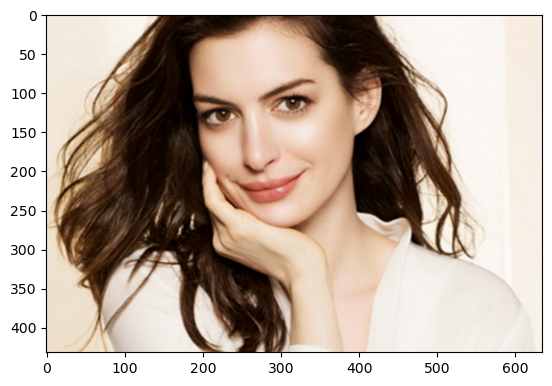

In [162]:
content_image_bgr = cv2.imread('content.png')
content_image_rgb = cv2.cvtColor(content_image_bgr,cv2.COLOR_BGR2RGB)
plt.imshow(content_image_rgb)

# Style Image

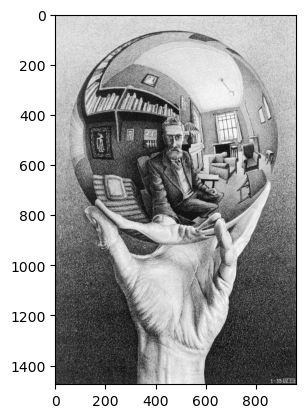

In [163]:
style_image_bgr = cv2.imread('style4.png')
style_image_rgb = cv2.cvtColor(style_image_bgr,cv2.COLOR_BGR2RGB)
plt.imshow(style_image_rgb)

# Load Image Path Function
##### Changes Image Size 
##### Transform Image matrix do Normalisation
##### Unsqueeze the image to make in the format of batch_size ,n_of_channels,height,width

In [164]:

def load_image(image_path, transform=None, max_size=None, shape=None):
    """Load an image and convert it to a torch tensor."""
    image = Image.open(image_path)
    
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
    
    if shape:
        image = image.resize(shape, Image.LANCZOS)
    
    if transform:
        image = transform(image).unsqueeze(0)
    
    return image.to(device)

# Model Architecture VGG-19 

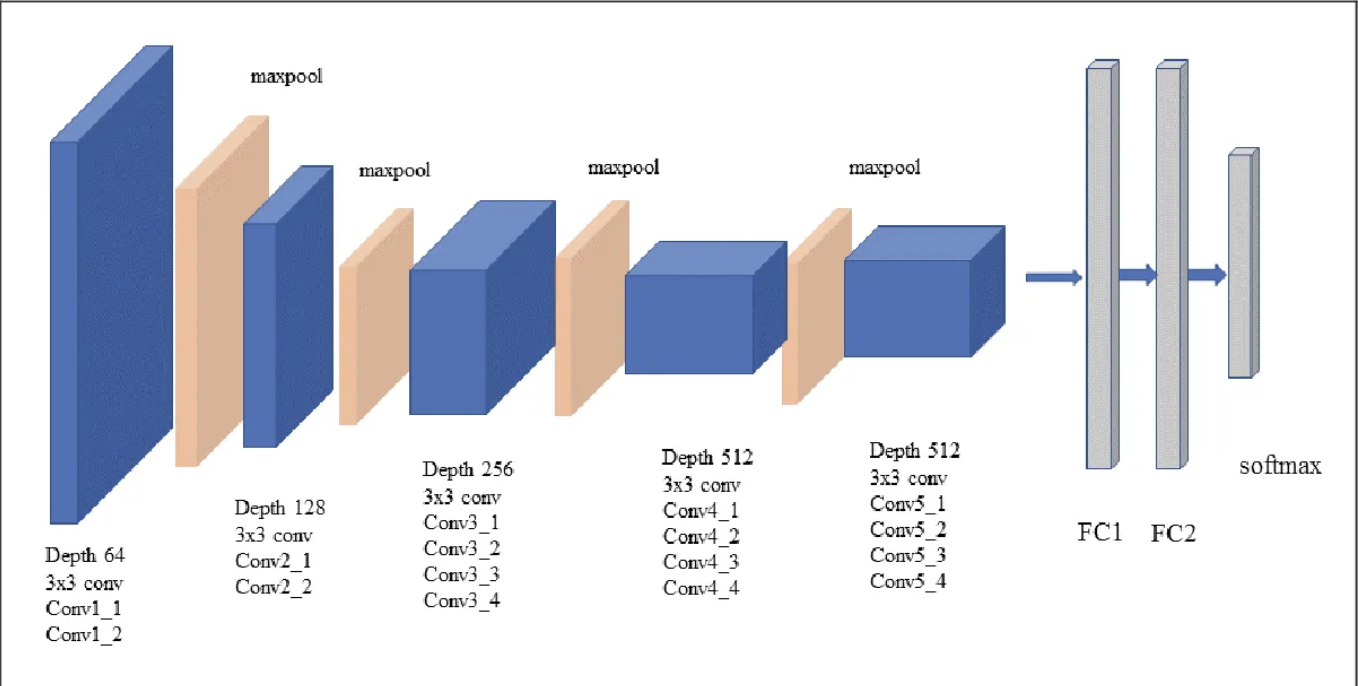

# Taking five layers for features
#### Conv1-1 (0th index)
#### Conv2-1(5th index)
#### Conv3-1(10th index)
#### Conv 4-1(19th index)
#### Conv5-1(28th index)

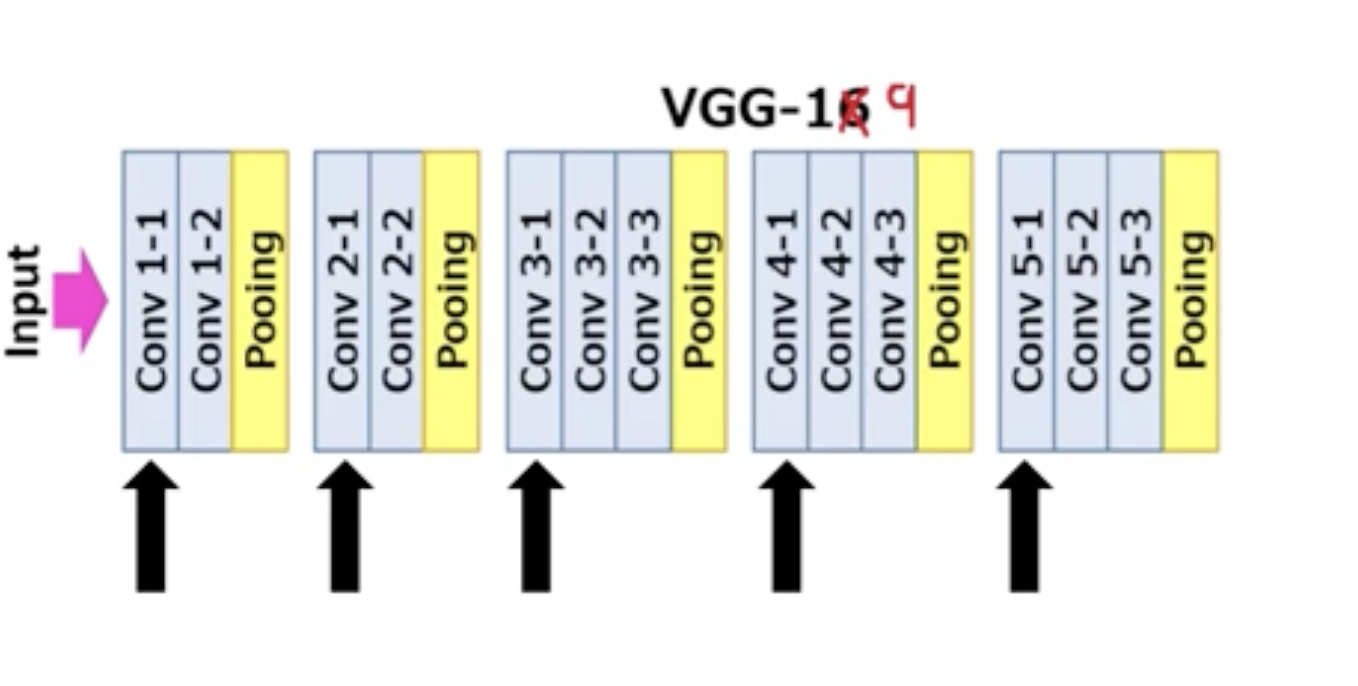

In [165]:
class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28'] ## Selecting those layers 
        self.vgg = models.vgg19(pretrained=True).features ### using pre trained vgg model
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features




# Image Proprocessing and Back-Propogation
##### Normalise the image
##### Learning rate is used as 1,Adam Optimiser is used
##### Forward Propogation using vgg.forward()
##### Find style loss and gram matrix

# Hyperparameters Used
#### max_image_size=350
#### learning_rate=0.1
#### epochs =250
#### Beta : -> weight to style loss =400

# Loss Function

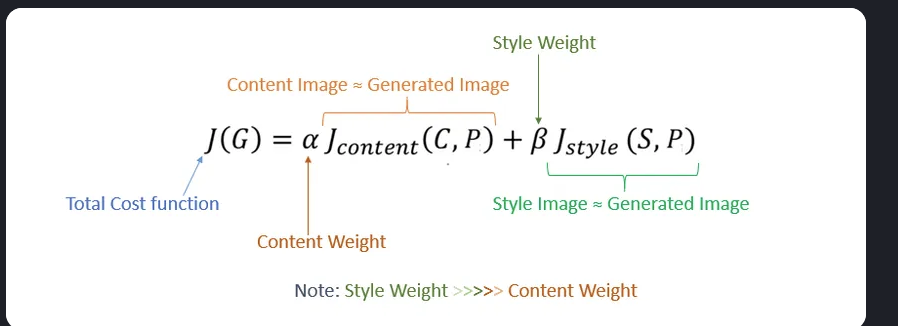

In [166]:


# Image preprocessing
# VGGNet was trained on ImageNet where images are normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
# We use the same normalization statistics here.
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                     std=(0.229, 0.224, 0.225))])

# Load content and style images
# Make the style image same size as the content image
content = load_image('content.png', transform, max_size=350)
style = load_image('style4.png', transform, shape=[content.size(2), content.size(3)])

# Initialize a target image with the content image
target = content.clone().requires_grad_(True)
# Applying Adam optimiser
optimizer = torch.optim.Adam([target], lr=0.1, betas=[0.5, 0.999])
# Making an object for a class
vgg = VGGNet()
# Store Loss in each epoch
loss_in_each_epoch=[]
for step in tqdm(range(100)):

    # Extract multiple(5) conv feature vectors
    target_features = vgg.forward(target)
    content_features = vgg.forward(content)
    style_features = vgg.forward(style)

    style_loss = 0
    content_loss = 0
    for f1, f2, f3 in zip(target_features, content_features, style_features):
        # Compute content loss with target and content images
        content_loss += torch.mean((f1 - f2)**2)

        # Reshape convolutional feature maps
        _, c, h, w = f1.size()
        f1 = f1.view(c, h * w)
        f3 = f3.view(c, h * w)

        # Compute gram matrix
        f1 = torch.mm(f1, f1.t())
        f3 = torch.mm(f3, f3.t())

        # Compute style loss with target and style images
        style_loss += torch.mean((f1 - f3)**2) / (c * h * w) 

    # Compute total loss, backprop and optimize
    loss = content_loss + 400 * style_loss 
    print(f"Loss in {step} epoch is : {loss}")
    loss_in_each_epoch.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



/var/folders/bc/k6hr84f57gqbdw0648c3tblw0000gn/T/ipykernel_3246/897374138.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(size.astype(int), Image.ANTIALIAS)
  0%|                                                                                                                                                                               | 0/100 [00:00<?, ?it/s]

Loss in 0 epoch is : 108241.5859375


  1%|█▋                                                                                                                                                                     | 1/100 [00:01<02:41,  1.63s/it]

Loss in 1 epoch is : 60302.64453125


  2%|███▎                                                                                                                                                                   | 2/100 [00:03<02:38,  1.61s/it]

Loss in 2 epoch is : 52969.140625


  3%|█████                                                                                                                                                                  | 3/100 [00:04<02:33,  1.58s/it]

Loss in 3 epoch is : 47926.14453125


  4%|██████▋                                                                                                                                                                | 4/100 [00:06<02:30,  1.56s/it]

Loss in 4 epoch is : 39763.53125


  5%|████████▎                                                                                                                                                              | 5/100 [00:07<02:27,  1.56s/it]

Loss in 5 epoch is : 35143.85546875


  6%|██████████                                                                                                                                                             | 6/100 [00:09<02:25,  1.54s/it]

Loss in 6 epoch is : 33025.99609375


  7%|███████████▋                                                                                                                                                           | 7/100 [00:10<02:22,  1.53s/it]

Loss in 7 epoch is : 31378.1015625


  8%|█████████████▎                                                                                                                                                         | 8/100 [00:12<02:20,  1.53s/it]

Loss in 8 epoch is : 29128.5703125


  9%|███████████████                                                                                                                                                        | 9/100 [00:13<02:20,  1.54s/it]

Loss in 9 epoch is : 27447.791015625


 10%|████████████████▌                                                                                                                                                     | 10/100 [00:15<02:20,  1.56s/it]

Loss in 10 epoch is : 27432.53125


 11%|██████████████████▎                                                                                                                                                   | 11/100 [00:17<02:19,  1.57s/it]

Loss in 11 epoch is : 25960.62109375


 12%|███████████████████▉                                                                                                                                                  | 12/100 [00:18<02:20,  1.60s/it]

Loss in 12 epoch is : 25051.513671875


 13%|█████████████████████▌                                                                                                                                                | 13/100 [00:20<02:17,  1.58s/it]

Loss in 13 epoch is : 24270.439453125


 14%|███████████████████████▏                                                                                                                                              | 14/100 [00:21<02:13,  1.56s/it]

Loss in 14 epoch is : 23117.0546875


 15%|████████████████████████▉                                                                                                                                             | 15/100 [00:23<02:10,  1.54s/it]

Loss in 15 epoch is : 21362.697265625


 16%|██████████████████████████▌                                                                                                                                           | 16/100 [00:24<02:08,  1.53s/it]

Loss in 16 epoch is : 20411.505859375


 17%|████████████████████████████▏                                                                                                                                         | 17/100 [00:26<02:07,  1.53s/it]

Loss in 17 epoch is : 19500.0078125


 18%|█████████████████████████████▉                                                                                                                                        | 18/100 [00:27<02:05,  1.53s/it]

Loss in 18 epoch is : 18862.068359375


 19%|███████████████████████████████▌                                                                                                                                      | 19/100 [00:29<02:03,  1.53s/it]

Loss in 19 epoch is : 17561.228515625


 20%|█████████████████████████████████▏                                                                                                                                    | 20/100 [00:30<02:01,  1.52s/it]

Loss in 20 epoch is : 16810.919921875


 21%|██████████████████████████████████▊                                                                                                                                   | 21/100 [00:32<02:00,  1.52s/it]

Loss in 21 epoch is : 16227.4609375


 22%|████████████████████████████████████▌                                                                                                                                 | 22/100 [00:34<01:58,  1.52s/it]

Loss in 22 epoch is : 15535.568359375


 23%|██████████████████████████████████████▏                                                                                                                               | 23/100 [00:35<01:57,  1.53s/it]

Loss in 23 epoch is : 14483.93359375


 24%|███████████████████████████████████████▊                                                                                                                              | 24/100 [00:37<01:57,  1.54s/it]

Loss in 24 epoch is : 13313.8095703125


 25%|█████████████████████████████████████████▌                                                                                                                            | 25/100 [00:38<01:54,  1.53s/it]

Loss in 25 epoch is : 12151.009765625


 26%|███████████████████████████████████████████▏                                                                                                                          | 26/100 [00:40<01:54,  1.55s/it]

Loss in 26 epoch is : 11051.4248046875


 27%|████████████████████████████████████████████▊                                                                                                                         | 27/100 [00:41<01:52,  1.54s/it]

Loss in 27 epoch is : 10001.7578125


 28%|██████████████████████████████████████████████▍                                                                                                                       | 28/100 [00:43<01:50,  1.53s/it]

Loss in 28 epoch is : 9362.1181640625


 29%|████████████████████████████████████████████████▏                                                                                                                     | 29/100 [00:44<01:48,  1.52s/it]

Loss in 29 epoch is : 8520.275390625


 30%|█████████████████████████████████████████████████▊                                                                                                                    | 30/100 [00:46<01:46,  1.52s/it]

Loss in 30 epoch is : 8811.2373046875


 31%|███████████████████████████████████████████████████▍                                                                                                                  | 31/100 [00:47<01:44,  1.51s/it]

Loss in 31 epoch is : 8482.0390625


 32%|█████████████████████████████████████████████████████                                                                                                                 | 32/100 [00:49<01:42,  1.51s/it]

Loss in 32 epoch is : 7352.11279296875


 33%|██████████████████████████████████████████████████████▊                                                                                                               | 33/100 [00:50<01:41,  1.51s/it]

Loss in 33 epoch is : 6590.18408203125


 34%|████████████████████████████████████████████████████████▍                                                                                                             | 34/100 [00:52<01:39,  1.51s/it]

Loss in 34 epoch is : 8614.6884765625


 35%|██████████████████████████████████████████████████████████                                                                                                            | 35/100 [00:53<01:40,  1.55s/it]

Loss in 35 epoch is : 12341.58984375


 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 36/100 [00:55<01:38,  1.55s/it]

Loss in 36 epoch is : 15071.0146484375


 37%|█████████████████████████████████████████████████████████████▍                                                                                                        | 37/100 [00:57<01:37,  1.55s/it]

Loss in 37 epoch is : 18562.59765625


 38%|███████████████████████████████████████████████████████████████                                                                                                       | 38/100 [00:58<01:35,  1.54s/it]

Loss in 38 epoch is : 16364.8017578125


 39%|████████████████████████████████████████████████████████████████▋                                                                                                     | 39/100 [01:00<01:34,  1.54s/it]

Loss in 39 epoch is : 15129.87890625


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 40/100 [01:01<01:35,  1.59s/it]

Loss in 40 epoch is : 13307.359375


 41%|████████████████████████████████████████████████████████████████████                                                                                                  | 41/100 [01:03<01:35,  1.61s/it]

Loss in 41 epoch is : 11900.6025390625


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 42/100 [01:05<01:35,  1.64s/it]

Loss in 42 epoch is : 10501.2412109375


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                              | 43/100 [01:06<01:34,  1.67s/it]

Loss in 43 epoch is : 9415.4833984375


 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 44/100 [01:08<01:33,  1.67s/it]

Loss in 44 epoch is : 7890.86376953125


 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                           | 45/100 [01:10<01:31,  1.66s/it]

Loss in 45 epoch is : 7492.408203125


 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 46/100 [01:11<01:27,  1.63s/it]

Loss in 46 epoch is : 6772.02490234375


 47%|██████████████████████████████████████████████████████████████████████████████                                                                                        | 47/100 [01:13<01:24,  1.60s/it]

Loss in 47 epoch is : 10745.6748046875


 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 48/100 [01:14<01:22,  1.58s/it]

Loss in 48 epoch is : 10412.8486328125


 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 49/100 [01:16<01:19,  1.57s/it]

Loss in 49 epoch is : 8129.2431640625


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 50/100 [01:17<01:17,  1.55s/it]

Loss in 50 epoch is : 7043.51806640625


 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 51/100 [01:19<01:15,  1.54s/it]

Loss in 51 epoch is : 5898.837890625


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 52/100 [01:20<01:13,  1.54s/it]

Loss in 52 epoch is : 5670.77294921875


 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 53/100 [01:22<01:12,  1.53s/it]

Loss in 53 epoch is : 5709.34326171875


 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 54/100 [01:23<01:10,  1.53s/it]

Loss in 54 epoch is : 12926.646484375


 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 55/100 [01:25<01:09,  1.54s/it]

Loss in 55 epoch is : 11747.640625


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 56/100 [01:27<01:07,  1.53s/it]

Loss in 56 epoch is : 10683.017578125


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 57/100 [01:28<01:05,  1.53s/it]

Loss in 57 epoch is : 9955.806640625


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 58/100 [01:30<01:04,  1.53s/it]

Loss in 58 epoch is : 9112.0498046875


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 59/100 [01:31<01:02,  1.52s/it]

Loss in 59 epoch is : 7844.79052734375


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 60/100 [01:33<01:00,  1.52s/it]

Loss in 60 epoch is : 6467.90576171875


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 61/100 [01:34<00:59,  1.52s/it]

Loss in 61 epoch is : 5540.6806640625


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 62/100 [01:36<00:57,  1.52s/it]

Loss in 62 epoch is : 4872.70849609375


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 63/100 [01:37<00:56,  1.52s/it]

Loss in 63 epoch is : 4554.4248046875


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 64/100 [01:39<00:54,  1.52s/it]

Loss in 64 epoch is : 4292.73583984375


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 65/100 [01:40<00:53,  1.52s/it]

Loss in 65 epoch is : 6148.505859375


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 66/100 [01:42<00:51,  1.52s/it]

Loss in 66 epoch is : 5151.6220703125


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 67/100 [01:43<00:50,  1.52s/it]

Loss in 67 epoch is : 4709.5107421875


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 68/100 [01:45<00:48,  1.52s/it]

Loss in 68 epoch is : 4349.80322265625


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 69/100 [01:46<00:47,  1.52s/it]

Loss in 69 epoch is : 6460.94091796875


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 70/100 [01:48<00:45,  1.52s/it]

Loss in 70 epoch is : 5947.4873046875


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 71/100 [01:49<00:44,  1.52s/it]

Loss in 71 epoch is : 5956.328125


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 72/100 [01:51<00:42,  1.52s/it]

Loss in 72 epoch is : 5288.95068359375


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 73/100 [01:52<00:41,  1.52s/it]

Loss in 73 epoch is : 9139.244140625


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 74/100 [01:54<00:39,  1.53s/it]

Loss in 74 epoch is : 11471.0859375


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 75/100 [01:55<00:38,  1.53s/it]

Loss in 75 epoch is : 10945.53125


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 76/100 [01:57<00:36,  1.52s/it]

Loss in 76 epoch is : 10221.6767578125


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 77/100 [01:59<00:35,  1.56s/it]

Loss in 77 epoch is : 9034.578125


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 78/100 [02:00<00:34,  1.57s/it]

Loss in 78 epoch is : 7818.46240234375


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 79/100 [02:02<00:33,  1.58s/it]

Loss in 79 epoch is : 7003.36181640625


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 80/100 [02:04<00:32,  1.61s/it]

Loss in 80 epoch is : 5911.1171875


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 81/100 [02:05<00:30,  1.62s/it]

Loss in 81 epoch is : 7331.44189453125


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 82/100 [02:07<00:29,  1.64s/it]

Loss in 82 epoch is : 5593.55029296875


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 83/100 [02:08<00:27,  1.62s/it]

Loss in 83 epoch is : 8817.1552734375


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 84/100 [02:10<00:25,  1.60s/it]

Loss in 84 epoch is : 8188.98095703125


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 85/100 [02:12<00:23,  1.59s/it]

Loss in 85 epoch is : 6244.54052734375


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 86/100 [02:13<00:22,  1.59s/it]

Loss in 86 epoch is : 5074.708984375


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 87/100 [02:15<00:20,  1.58s/it]

Loss in 87 epoch is : 6483.98388671875


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 88/100 [02:16<00:19,  1.59s/it]

Loss in 88 epoch is : 5244.43798828125


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 89/100 [02:18<00:17,  1.58s/it]

Loss in 89 epoch is : 10786.9189453125


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 90/100 [02:19<00:15,  1.56s/it]

Loss in 90 epoch is : 11942.29296875


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 91/100 [02:21<00:13,  1.55s/it]

Loss in 91 epoch is : 8932.171875


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 92/100 [02:22<00:12,  1.54s/it]

Loss in 92 epoch is : 7852.15673828125


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 93/100 [02:24<00:10,  1.53s/it]

Loss in 93 epoch is : 6070.8603515625


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 94/100 [02:25<00:09,  1.53s/it]

Loss in 94 epoch is : 5612.30908203125


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 95/100 [02:27<00:07,  1.53s/it]

Loss in 95 epoch is : 5451.14111328125


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 96/100 [02:28<00:06,  1.54s/it]

Loss in 96 epoch is : 10673.267578125


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 97/100 [02:30<00:04,  1.53s/it]

Loss in 97 epoch is : 6457.18359375


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 98/100 [02:32<00:03,  1.53s/it]

Loss in 98 epoch is : 5613.5087890625


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 99/100 [02:33<00:01,  1.53s/it]

Loss in 99 epoch is : 4711.58056640625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


# Loss Across Epochs

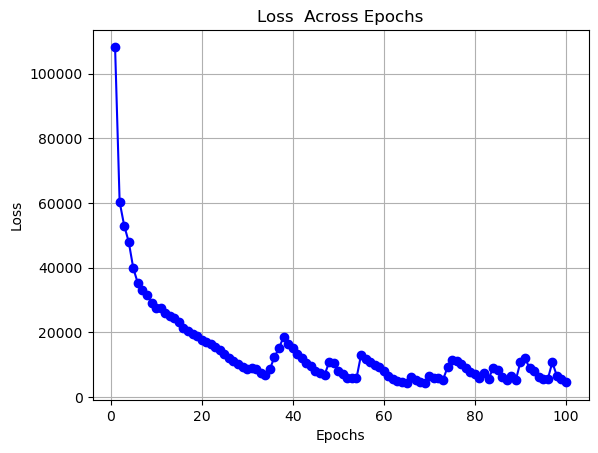

In [167]:
loss_in_each_epoch = [tensor.detach().numpy() for tensor in loss_in_each_epoch]

epochs = range(1, len(loss_in_each_epoch) + 1)

# Plot the graph
plt.plot(epochs, loss_in_each_epoch, marker='o', linestyle='-', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss  Across Epochs')
plt.grid(True)
plt.show()


### Denormalise the output
### clone and squeeze
### clip between 0 to 1

In [168]:
denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
img = target.clone().squeeze()
img = denorm(img).clamp_(0, 1)
torchvision.utils.save_image(img, 'output.png')


# Resultant Image based upon the style

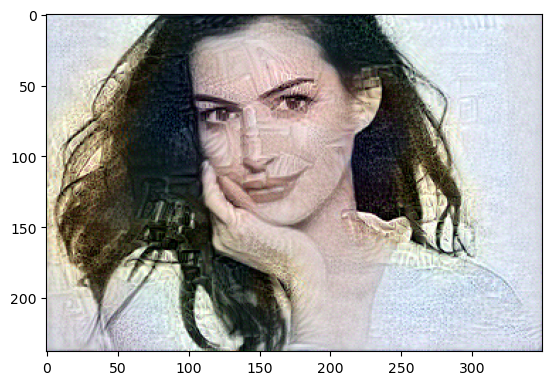

In [169]:
resultant_image_bgr =cv2.imread('output.png')
resultant_image_rgb = cv2.cvtColor(resultant_image_bgr,cv2.COLOR_BGR2RGB)
plt.imshow(resultant_image_rgb)

## Possible Limitations and Future Improvements
#### Computational Intensity: Neural Style Transfer, especially when utilizing VGGnet 19 weights, can be computationally intensive. This might make it challenging to apply the model in real-time or on devices with limited resources.

#### Fixed Style Reference:The model relies on a fixed style reference image. This can be limiting as the user has no direct control over the style during the generation process.


## Improvements

####  Model Architectures:Experiment with different neural network architectures. Recent advancements in neural style transfer include models like the Adaptive Instance Normalization (AdaIN) and Neural Style Transfer with Progressive Networks.
#### Dynamic Style Control: Implement mechanisms for dynamic style control during the generation process. This could involve user interactions or learning to adaptively incorporate different style influences.